ENSEMBLE METHOD

We are integrating the fine tuned bert rather than the other two(bert as a feature extractor and tf idf implementation) to make predictions on textual features as fine tuning performed the best on data.
New dataset 'ensemble_test_updated.csv' is used to avoid overfitting by any of the two models.
We have implemented K-fold stacking ensemble to avoid further overfitting.
Used logistic regression as meta model.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

 Ensemble Model Evaluation (on held-out meta test sets):
Accuracy     : 0.9718
Precision    : 0.9595
Recall       : 0.9861
F1 Score     : 0.9726
ROC AUC Score: 0.9958

Meta-Model Weights (How much it trusts each base model):
Numerical Model (w1): 0.4455
NLP Model       (w2): 1.6719
Bias (Intercept):    -1.1500

 Trust Breakdown:
Numerical Model: 21.0%
NLP Model:       79.0%


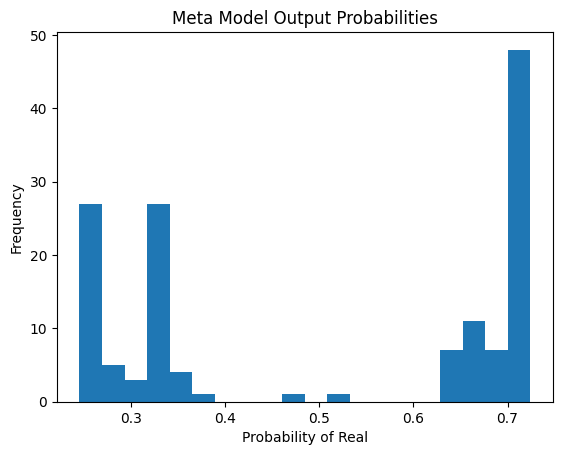

In [ ]:
import pandas as pd
import numpy as np
import joblib
import torch
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# -------------------- Load Pretrained Models --------------------
class KerasModelWrapper:
    def __init__(self, model):
        self.model = model

    def predict_proba(self, X):
        return self.model.predict(X)

class BertWrapper:
    def __init__(self, model, tokenizer, device='cpu'):
        self.model = model.to(device)
        self.tokenizer = tokenizer
        self.device = device
        self.model.eval()

    def predict_proba(self, texts):
        all_probs = []
        with torch.no_grad():
            for i in range(0, len(texts), 16):
                batch = texts[i:i+16]
                encodings = self.tokenizer(
                    batch,
                    truncation=True,
                    padding=True,
                    return_tensors='pt',
                    max_length=128
                )
                input_ids = encodings['input_ids'].to(self.device)
                attention_mask = encodings['attention_mask'].to(self.device)

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                probs = torch.nn.functional.softmax(outputs.logits, dim=1)[:, 1]
                all_probs.extend(probs.cpu().numpy())
        return np.array(all_probs).reshape(-1, 1)

# Load models
num_model = joblib.load('keras_model_wrapper1.pkl')
nlp_model = joblib.load('bert_model.pkl')
scaler = joblib.load('numerical_scaler.pkl')

# -------------------- Load and Preprocess Dataset --------------------
df = pd.read_csv('ensemble_test_updated.csv')
rename_map = {
    'Full Name': 'Full_Name',
    'Followers': '#followers',
    'Following': '#follows',
    'Is Private': 'private',
    'Number of Posts': '#posts'
}
df = df.rename(columns=rename_map)

numerical_features_model = [
    'nums/length username',
    'nums/length fullname',
    'description length',
    'private',
    '#posts',
    '#followers',
    '#follows'
]

X_num = df[numerical_features_model].values
X_text = df[['Username', 'Full_Name', 'Bio']].fillna('').agg(' '.join, axis=1).tolist()
y = df['Real'].values

X_num_scaled = scaler.transform(X_num)

# -------------------- K-Fold Stacking --------------------
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
meta_features = []
meta_labels = []

for train_idx, val_idx in kf.split(X_num_scaled, y):
    X_train_num, X_val_num = X_num_scaled[train_idx], X_num_scaled[val_idx]
    X_train_text = [X_text[i] for i in train_idx]
    X_val_text = [X_text[i] for i in val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Base model predictions
    probs_num = num_model.predict_proba(X_val_num)[:, 1]
    # We have to flip this as for num model the target column was fake and not real
    probs_num_flipped = 1 - probs_num

    probs_nlp = nlp_model.predict_proba(X_val_text).ravel()

    X_fold_meta = np.column_stack((probs_num_flipped, probs_nlp))
    meta_features.append(X_fold_meta)
    meta_labels.append(y_val)

X_meta = np.vstack(meta_features)
y_meta = np.hstack(meta_labels)

# -------------------- Train Meta Model --------------------
meta_model = LogisticRegression(C=0.09)  # tuned C
meta_model.fit(X_meta, y_meta)

# -------------------- Evaluate --------------------
final_probs = meta_model.predict_proba(X_meta)[:, 1]
final_preds = meta_model.predict(X_meta)

acc = accuracy_score(y_meta, final_preds)
precision = precision_score(y_meta, final_preds)
recall = recall_score(y_meta, final_preds)
f1 = f1_score(y_meta, final_preds)
roc_auc = roc_auc_score(y_meta, final_probs)

print("\n Ensemble Model Evaluation (on held-out meta test sets):")
print(f"Accuracy     : {acc:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# -------------------- Meta Model Weights --------------------
w1, w2 = meta_model.coef_[0]
bias = meta_model.intercept_[0]
total_weight = abs(w1) + abs(w2)
pct_num = abs(w1) / total_weight * 100
pct_nlp = abs(w2) / total_weight * 100

print("\nMeta-Model Weights (How much it trusts each base model):")
print(f"Numerical Model (w1): {w1:.4f}")
print(f"NLP Model       (w2): {w2:.4f}")
print(f"Bias (Intercept):    {bias:.4f}")

print(f"\n Trust Breakdown:")
print(f"Numerical Model: {pct_num:.1f}%")
print(f"NLP Model:       {pct_nlp:.1f}%")

# --------------------  Histogram --------------------
plt.hist(final_probs, bins=20)
plt.title("Meta Model Output Probabilities")
plt.xlabel("Probability of Real")
plt.ylabel("Frequency")
plt.show()


The distribution has clusters forming near:
  - 0.25–0.35 → likely **fake accounts**
  - 0.65–0.72 → likely **real accounts**
  - ~0.5 → **uncertain cases** where the model isn't confident

- The meta-model  confidently leans toward classifying 
  most accounts as either fake or real, with only a few borderline predictions.
- This separation reflects an **effective fusion** of both the numerical and NLP 
  base models via stacking.
- The model is demonstrating strong discriminative ability,making it suitable for deployment

In [ ]:
import joblib

# Save the meta model
joblib.dump(meta_model, 'meta_model.pkl')



['meta_model.pkl']

DEPLOYMENT


In [ ]:
import instaloader
import time
import pandas as pd
import numpy as np
import joblib
import torch

# ---------- Load Trained Models -----------------
num_model = joblib.load("keras_model_wrapper1.pkl")
nlp_model = joblib.load("bert_model.pkl")
scaler = joblib.load("numerical_scaler.pkl")
meta_model = joblib.load("meta_model.pkl")

# ------------------- Instagram Scraper -------------------
L = instaloader.Instaloader()

def scrape_instagram_profile(username):
    try:
        profile = instaloader.Profile.from_username(L.context, username)
        return {
            "Username": profile.username,
            "Full_Name": profile.full_name,
            "Bio": profile.biography,
            "private": int(profile.is_private),
            "#posts": profile.mediacount,
            "#followers": profile.followers,
            "#follows": profile.followees
        }
    except instaloader.exceptions.ProfileNotExistsException:
        return {"Error": "Profile does not exist", "Username": username}
    except instaloader.exceptions.InstaloaderException as e:
        if "Please wait a few minutes" in str(e):
            print("⏳ Rate limited. Waiting 10 minutes...")
            time.sleep(600)
            return scrape_instagram_profile(username)
        return {"Error": str(e), "Username": username}

# ------------------- Feature Engineering --------------------
def digit_ratio(text):
    if not isinstance(text, str) or len(text) == 0:
        return 0
    return sum(c.isdigit() for c in text) / len(text)

def transform_to_features(profile):
    if "Error" in profile:
        return None  # Skip if not valid

    # Compute numerical features
    return {
        "Username": profile["Username"],
        "Full_Name": profile["Full_Name"],
        "Bio": profile["Bio"],
        "private": profile["private"],
        "#posts": profile["#posts"],
        "#followers": profile["#followers"],
        "#follows": profile["#follows"],
        "nums/length username": digit_ratio(profile["Username"]),
        "nums/length fullname": digit_ratio(profile["Full_Name"]),
        "description length": len(str(profile["Bio"])) if profile["Bio"] else 0
    }

# ----------- Prediction --------------
def predict_fake_or_real(features):
    num_cols = [
        "nums/length username",
        "nums/length fullname",
        "description length",
        "private",
        "#posts",
        "#followers",
        "#follows"
    ]
    x_num = [features[col] for col in num_cols]
    x_num_scaled = scaler.transform([x_num])
    p_num = 1 - num_model.predict_proba(x_num_scaled)[0, 1]  # flip to real

    text_input = [f"{features['Username']} {features['Full_Name']} {features['Bio']}"]
    p_nlp = nlp_model.predict_proba(text_input).ravel()[0]

    x_meta = np.array([[p_num, p_nlp]])
    final_pred = meta_model.predict(x_meta)[0]
    final_prob = meta_model.predict_proba(x_meta)[0, 1]

    return final_pred, final_prob

# -------------- Input --------------
# Some real(actually on insta) usernames to scrape, you can change to check for your choice of usernames
real_usernames = [
    "agnesgrochulska", "iitg_memechannel", "shirish_sharma_001"
]

# Some fake data (manually entered) this can also be data from a real account but you can randomly make ai generate a fake account to detect
manual_profiles = [
    {
        "Username": "anjalianjali",
        "Full_Name": "mehta",
        "Bio": " ",
        "private": 0,
        "#posts": 2,
        "#followers": 10,
        "#follows": 1000
    },
    {
        "Username": "nomo123",
        "Full_Name": "NoMOchan",
        "Bio": "Tasting my way through life 🍕🍣 #Foodie",
        "private": 1,
        "#posts": 0,
        "#followers": 0,
        "#follows": 0
    }
]

# -------------- Run Predictions ---------------
print("\n Starting predictions:\n")

# Scraped ones
for username in real_usernames:
    print(f" @{username} (Scraped):")
    raw_profile = scrape_instagram_profile(username)
    features = transform_to_features(raw_profile)

    if features:
        pred, prob = predict_fake_or_real(features)
        label = "REAL" if pred == 1 else "FAKE"
        print(f" → Prediction: {label} (confidence: {prob:.2f})\n")
    else:
        print(f" → Could not scrape: {raw_profile.get('Error')}\n")

    time.sleep(5)  # Rate limit protection

# Manual ones
for profile in manual_profiles:
    print(f" {profile['Username']} (Manual Input):")
    features = transform_to_features(profile)
    pred, prob = predict_fake_or_real(features)
    label = "REAL" if pred == 1 else "FAKE"
    print(f" → Prediction: {label} (confidence: {prob:.2f})\n")



 Starting predictions:

 @agnesgrochulska (Scraped):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


 → Prediction: FAKE (confidence: 0.49)

 @iitg_memechannel (Scraped):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


 → Prediction: REAL (confidence: 0.72)

 @shirish_sharma_001 (Scraped):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


 → Prediction: REAL (confidence: 0.72)

 anjalianjali (Manual Input):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
 → Prediction: REAL (confidence: 0.68)

 nomo123 (Manual Input):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


 → Prediction: FAKE (confidence: 0.47)

